In [3]:
import numpy as np
import scipy 
import os
import matplotlib.pyplot as plot
import math
from scipy import ndimage
from skimage import io

plot.rcParams['image.interpolation'] = 'nearest'
plot.rcParams['image.cmap'] = 'gray'

Zero padding changes shape of inputs to conform to expected shapes

x shape (num examples, height, width, 3)

In [4]:
def zeroPadding(x,pad_size): 
    x = np.pad(x, ((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0,0)), "constant" )
    return x 

x (4, 3, 3, 2)
PaddedX (4, 9, 9, 2)


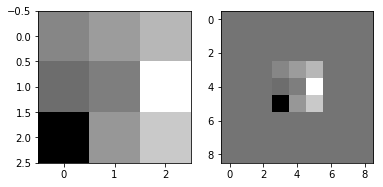

In [5]:
np.random.seed(17)
x = np.random.randn(4,3,3,2)
paddedX = zeroPadding(x,3)
print("x",x.shape)
print("PaddedX",paddedX.shape)

figure, array = plot.subplots(1, 2)
array[0].imshow(x[0, :, :, 0])
#plot.show()
array[1].imshow(paddedX[0, :, :, 0])
plot.show()

In [6]:
def convolution(x, w, b):
    # x.shape == (f, f, number of channels in previous layer)
    # w.shape == (f, f, number of channels in previous layer)
    # b.shape == (1, 1, 1)
    z = x * w 
    z = np.sum(z) + float(b)
    return z  

In [7]:
np.random.seed(17)
x = np.random.randn(4,4,3)
w = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)
z = convolution(x,w,b)
print("z",z)

z 2.39921868021


z = 28.7210842132

In [30]:
def convolveFoward(x, weights, b, stride_length, pad_value):
    num_examples, height, width, pre_channels = np.shape(x)
    window_side_length, window_side_length, pre_channels, cur_channels = np.shape(weights)
    # Equation to compute new height and width dimensions
    new_height = int((height + 2 * pad_value - window_side_length) / stride_length) + 1
    new_width = int((width + 2 * pad_value - window_side_length) / stride_length) + 1
    z = np.zeros((num_examples, new_height, new_width, cur_channels)) #new channels for z shape
    #z is placeholders for output
    paddedX = zeroPadding(x,pad_value)
    print("widths",new_width * window_side_length, width)
    for i in range(num_examples):
        curr_example = paddedX[i]
        for h in range(new_height): #iterating through new heigth of layer dimensions
            for w in range(new_width): #iterating through new width of layer dimensions
                for c in range(cur_channels):
                    #fetches current widow to convolve
                    h_start = h * stride_length
                    h_end = h_start + window_side_length
                    w_start = w * stride_length
                    w_end = w_start + window_side_length
                    cur_slice = curr_example[h_start:h_end, w_start:w_end, :]
                    
                    cur_z = convolution(cur_slice,weights[:,:,:,c], b[:,:,:,c])
                    z[i,h,w,c] = cur_z

    cache = {"w":weights,"b":b,"x":x, "stride_length":stride_length,"pad_value":pad_value}
    return z, cache

In [11]:
np.random.seed(1)
x = np.random.randn(10,4,4,3)
# weights (window_side_length, widnow_side_length, num channels in previous layer, new num channels)
weights = np.random.randn(2,2,3,8)
biases = np.random.randn(1,1,1,8)
pad_value = 2
stride_length = 2
z,_ = convolveFoward(x,weights, biases, stride_length, pad_value)
print("z shape",np.shape(z))
print("mean",np.mean(z))



widths 8 4
z shape (10, 4, 4, 8)
mean 0.0489952035289


In [16]:
def pool(X,pad_value,stride_length,pool_type):
    num_examples, prev_height, prev_width, prev_num_channels = X.shape
#     new_width = int((prev_width + 2 * pad_value - window_side_length) / stride_length) + 1
#     new_height = int((prev_height + 2 * pad_value - window_side_length) / stride_length) + 1
    new_width = int(((prev_width - pad_value) /stride_length) + 1)
    new_height = int(((prev_height - pad_value) / stride_length) + 1)
    z = np.zeros((num_examples,new_height,new_width,prev_num_channels))
    for e in range(num_examples):
        for w in range(new_width):
            for h in range(new_height):
                for c in range(prev_num_channels):
                    h_start = h * stride_length
                    h_end = h_start + pad_value
                    w_start = w * stride_length
                    w_end = w_start + pad_value
                    cur_window = X[e,h_start:h_end,w_start:w_end,c]
                    if pool_type == "max":
                        z[e,h,w,c] = np.max(cur_window)
                    if pool_type == "avg":
                        z[e,h,w,c] = np.mean(cur_window)
    cache = {"x":X, "stride_length":stride_length,"pad_value":pad_value}
    return z, cache

In [22]:
np.random.seed(1)
X = np.random.randn(2,4,4,3)
pad_value = 3
stride_length = 2
z , cache = pool(X, pad_value, stride_length, "max")
print(z.shape)
print("max",z)
z , cache = pool(X, pad_value, stride_length, "avg")
print(z.shape)
print("avg",z)

(2, 1, 1, 3)
max [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]
(2, 1, 1, 3)
avg [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


w/ np.random.seed(1) X = np.random.randn(2,4,4,3) pad_value = 3 stride_length = 2
(2, 1, 1, 3)
max [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]
(2, 1, 1, 3)
avg [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


In [65]:
def convBack(dZ,cache):
    weights, b, pad_value, x, stride_length, pad_value = cache["w"], cache["b"], cache["pad_value"], cache["x"], cache["stride_length"], cache["pad_value"]
    num_examples, prev_height, prev_width, prev_num_channels = x.shape
    window_height, window_width, prev_num_channels, cur_num_channels = weights.shape
    num_examples, cur_height, cur_width, cur_num_channels  = dZ.shape
    dW = np.zeros(weights.shape)
    dB = np.zeros(b.shape)
    dA = np.zeros(x.shape)
    
    dA_padded = zeroPadding(dA, pad_value)
    x_padded = zeroPadding(x, pad_value)
    
    print("dA shape", dA.shape)
    for e in range(num_examples):
        cur_example_dA = dA_padded[e,:,:,:]
        cur_example_x = x_padded[e,:,:,:]
        
        for h in range(cur_height):
            for w in range(cur_width):
                for c in range(cur_num_channels):
                    h_start = h * stride_length
                    h_end = h_start + pad_value
                    w_start = w * stride_length
                    w_end = w_start + pad_value
                    
                    cur_slice_x = x_padded[h_start:h_end,w_start:w_end,c]
                    cur_example_dA[h_start:h_end,w_start:w_end,:] += weights[:,:,:,c] * dZ[e,h,w,c]
                    dW[:,:,:,c] += cur_slice_x * dZ[e,h,w,c]
                    dB[:,:,:,c] += dZ[e,h,w,c]
                    
        dA[e,:,:,:] = dA[pad_value:-pad_value, pad_value:-pad_value, :] #unpads dA
    grads = {"dW":dW,"dB":dB,"dA":dA}         
    return grads        

In [66]:
np.random.seed(1)
x = np.random.randn(10,4,4,3)
# weights (window_side_length, widnow_side_length, num channels in previous layer, new num channels)
weights = np.random.randn(2,2,3,8)
biases = np.random.randn(1,1,1,8)
pad_value = 2
stride_length = 2
z,cache = convolveFoward(x,weights, biases, stride_length, pad_value)
convBack(z,cache)

widths 8 4
dA shape (10, 4, 4, 3)


ValueError: could not broadcast input array from shape (6,0,4,3) into shape (4,4,3)

In [71]:
def init_mask(x):
    return (x == np.max(x))

In [73]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = init_mask(x)
print("x",x)
print("mask",mask)

x [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask [[ True False False]
 [False False False]]


In [76]:
def int_avg_mask(avg,output_shape):
    num_values = output_shape[0] *  output_shape[1]
    value = avg/num_values
    return np.ones(output_shape) * value


In [78]:
x = int_avg_mask(1,(2,2))
print(x)

[[ 0.25  0.25]
 [ 0.25  0.25]]
